In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import h5py

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style('whitegrid')
sns.set()
%config InlineBackend.figure_format = 'retina'
import cv2 as cv

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, r2_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, VotingClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import io

import time

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c isic-2024-challenge
!unzip /content/isic-2024-challenge.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/train-image/image/ISIC_9874656.jpg  
  inflating: /content/train-image/image/ISIC_9874659.jpg  
  inflating: /content/train-image/image/ISIC_9874663.jpg  
  inflating: /content/train-image/image/ISIC_9874742.jpg  
  inflating: /content/train-image/image/ISIC_9874751.jpg  
  inflating: /content/train-image/image/ISIC_9874803.jpg  
  inflating: /content/train-image/image/ISIC_9874805.jpg  
  inflating: /content/train-image/image/ISIC_9874832.jpg  
  inflating: /content/train-image/image/ISIC_9874878.jpg  
  inflating: /content/train-image/image/ISIC_9874897.jpg  
  inflating: /content/train-image/image/ISIC_9874925.jpg  
  inflating: /content/train-image/image/ISIC_9874931.jpg  
  inflating: /content/train-image/image/ISIC_9874939.jpg  
  inflating: /content/train-image/image/ISIC_9874940.jpg  
  inflating: /content/train-image/image/ISIC_9874963.jpg  
  inflating: /content/train-image/image/ISIC_9874987.jpg  
  inf

In [ ]:
!ls /content/

isic-2024-challenge.zip  sample_submission.csv	test-metadata.csv  train-image.hdf5
sample_data		 test-image.hdf5	train-image	   train-metadata.csv


In [ ]:
# Define random state for reproducibility
RANDOM_STATE = 11

# Load training metadata from the Kaggle dataset
train_metadata = pd.read_csv('/content/train-metadata.csv')

# Display the first few rows of the metadata
print("First few rows of the training metadata:")
print(train_metadata.head())

# Display the shape and columns of the metadata DataFrame
print("\nShape of the training metadata:", train_metadata.shape)
print("Columns in the training metadata:", train_metadata.columns.tolist())

# Count of unique ISIC IDs and target value counts
unique_isic_ids = train_metadata.isic_id.nunique()
print("\nUnique ISIC IDs:", unique_isic_ids)
print("Target value counts:")
print(train_metadata.target.value_counts())

# Target: Binary class {0: benign, 1: malignant}
# Count of males and females
sex_counts = train_metadata.sex.value_counts()
print("\nCount of males and females in the dataset:")
print(sex_counts)

<ipython-input-4-bb558c7b1c6b>:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv('/content/train-metadata.csv')


First few rows of the training metadata:
        isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3D: white  20.244422  ...   
1                    1.10  TBP tile: close-up     3D: white  31.712570  ...   
2                    3.40  TBP tile: close-up        3D: XP  22.575830  ...   
3                    3.22  TBP tile: close-up        3D: XP  14.242329  ...   
4                    2.73  TBP tile: close-up     3D: white  24.725520  ...   

    lesion_id  iddx_f

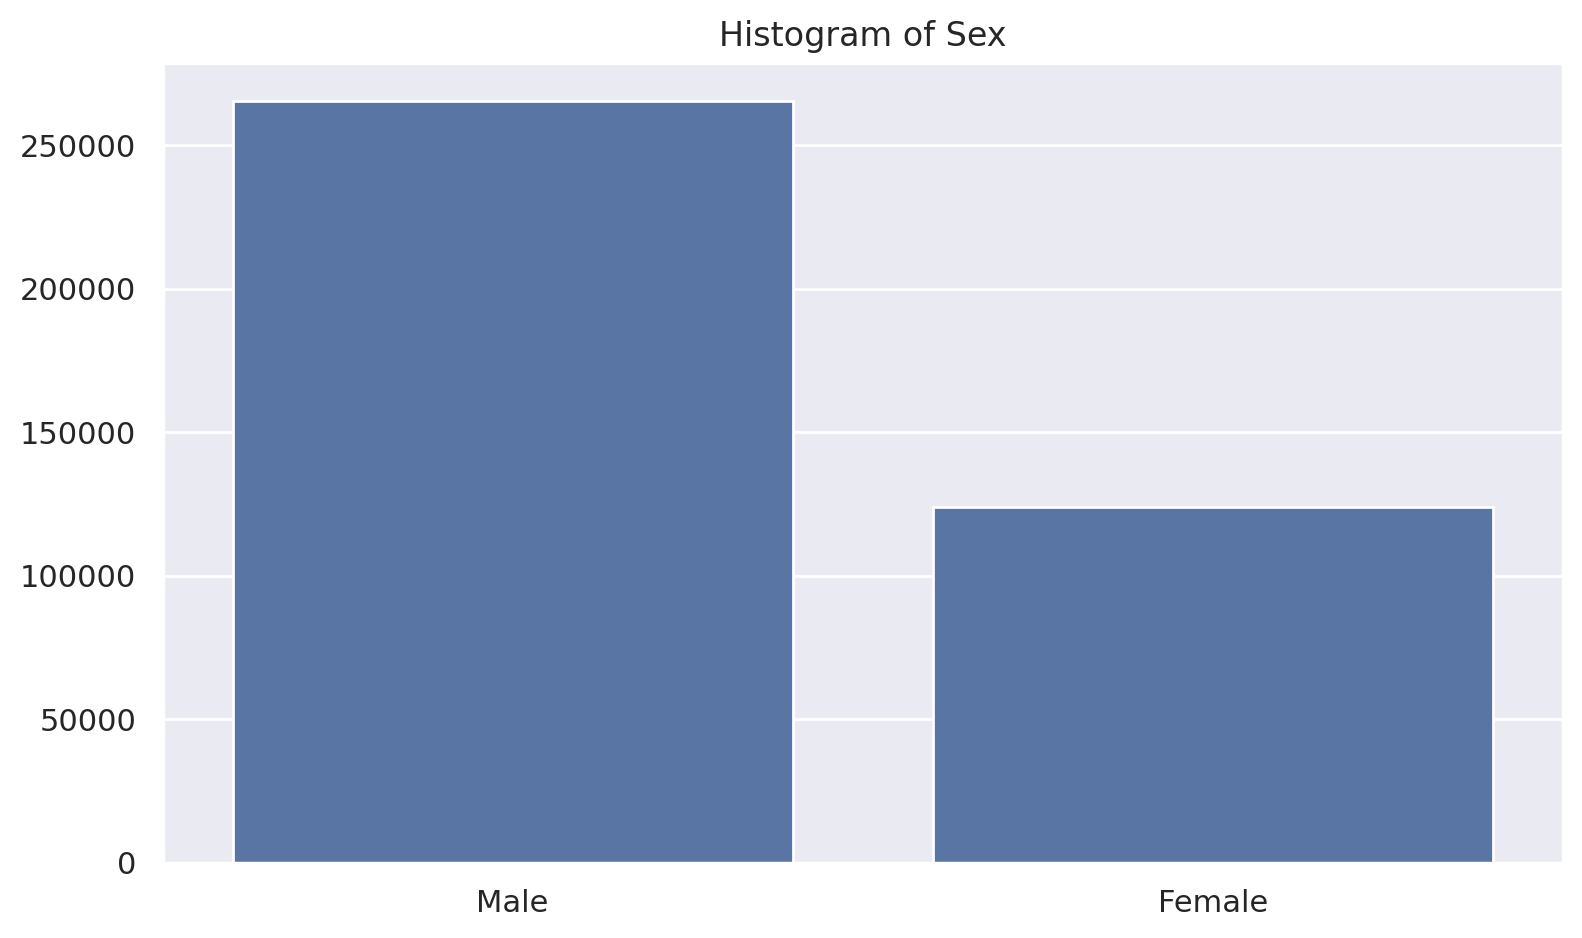

In [ ]:
# Plotting histogram of sex distribution
fig = plt.figure(figsize=(7, 4))
ax = fig.add_axes([0, 0, 1, 1])
sns.countplot(x='sex', data=train_metadata, ax=ax)

ax.set_xticks(range(2))
ax.set_xticklabels(['Male', 'Female'])
ax.set_title('Histogram of Sex')
ax.set_ylabel('')
ax.set_xlabel('')

plt.show()


In [ ]:
# Load images from HDF5 file
train_image = h5py.File('/content/train-image.hdf5', 'r')

# List keys and check the number of images
list(train_image.keys())[:5]
len(train_image.keys())

# Access a specific image
train_image['ISIC_0015670']


<HDF5 dataset "ISIC_0015670": shape (), type "|S3325">

In [ ]:
# Separate malignant and non-malignant tumors
malignant_tumors = train_metadata[train_metadata['target'] == 1]
non_malignant_tumors = train_metadata[train_metadata['target'] == 0]

# Sample from non-malignant tumors
non_malignant_sample = non_malignant_tumors.sample(n=500, random_state=123)

# Combine the two datasets
combined_tumors = pd.concat([malignant_tumors, non_malignant_sample])

# Check the target value counts in the combined dataset
combined_tumors.target.value_counts()
combined_tumors.head()

# Load images for the combined dataset
X_data = []
for identification in combined_tumors['isic_id']:
    buffer_image = train_image[identification][()]
    image_array = np.frombuffer(buffer_image, dtype=np.uint8)
    image_bgr = cv.imdecode(image_array, cv.IMREAD_COLOR)
    image_rgb = cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB)
    resized_image = cv.resize(image_rgb, (121, 121))
    X_data.append(resized_image)

X_data = np.array(X_data)
y_data = combined_tumors.target


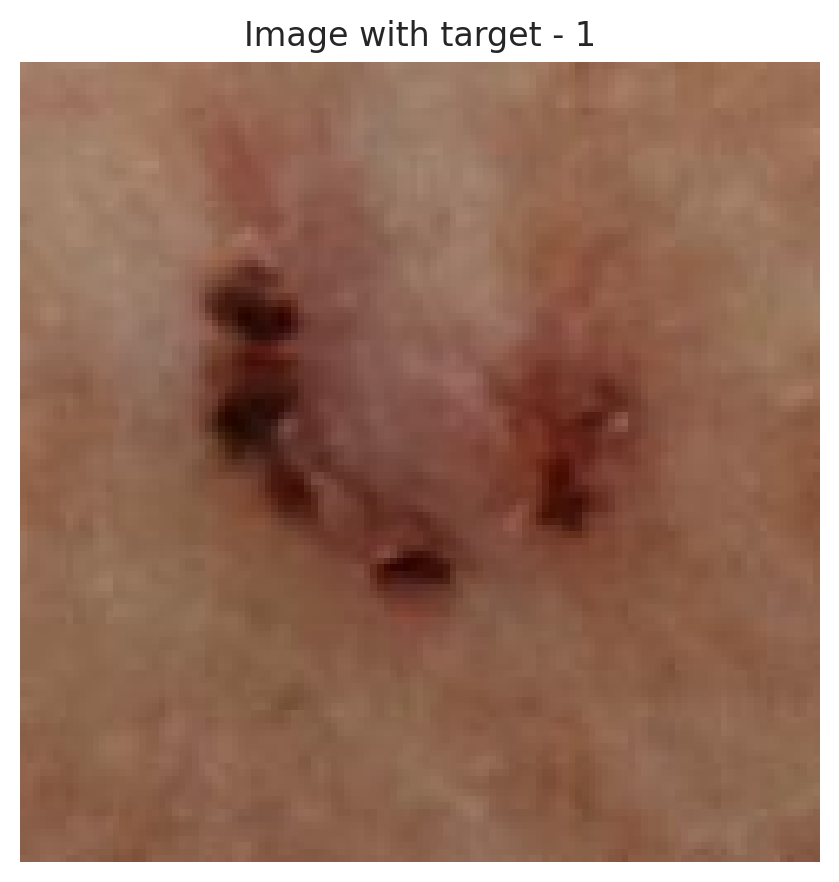

In [ ]:
# Display an example image
index_of_image = 0
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('Image with target - %s' % combined_tumors['target'].iat[index_of_image])
ax.imshow(X_data[index_of_image])
plt.axis(False)
plt.show()


Unique labels in the dataset: [0 1]


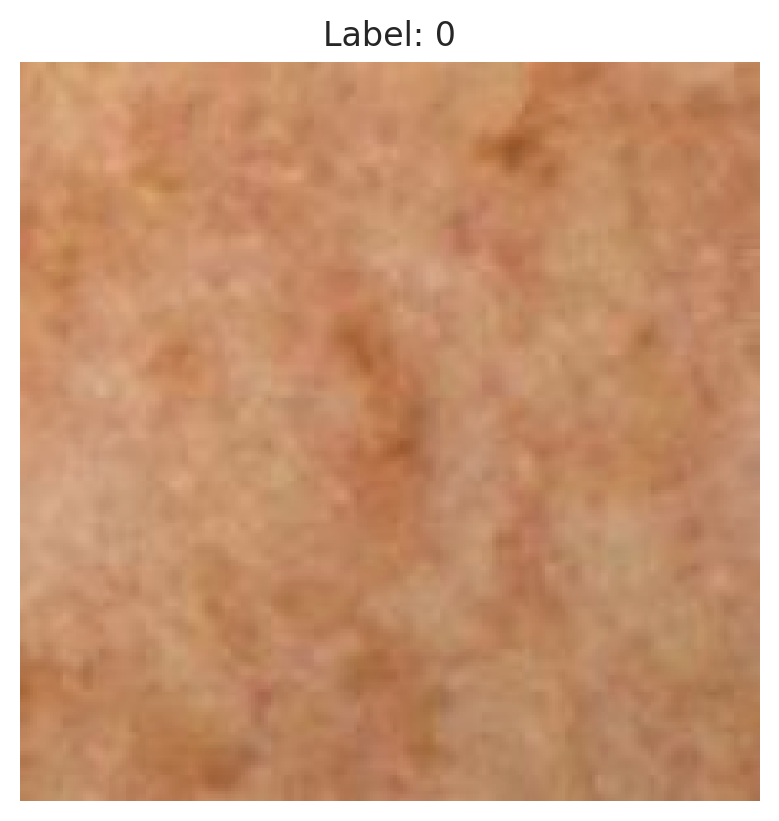

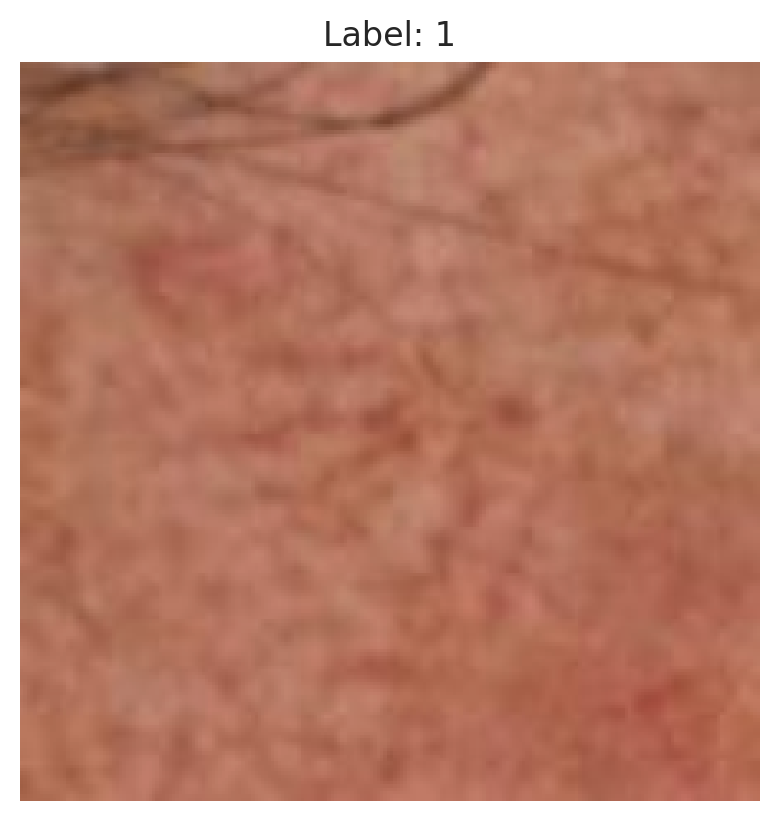

In [ ]:
# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define custom dataset class
class CombinedDataset(Dataset):
    def __init__(self, hdf5_file_path, metadata_df, transform=None):
        self.hdf5_file = h5py.File(hdf5_file_path, 'r')
        self.metadata_df = metadata_df
        self.transform = transform
        isic_ids_set = set(self.metadata_df['isic_id'].values)
        self.image_ids = [img_id for img_id in self.hdf5_file.keys() if img_id in isic_ids_set]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_bytes = self.hdf5_file[image_id][()]
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        label = self.metadata_df.loc[self.metadata_df['isic_id'] == image_id, 'target'].values
        label = label[0] if len(label) > 0 else -1

        if self.transform:
            image = self.transform(image)

        return image, label

# Load datasets
hdf5_file_path = '/content/train-image.hdf5'
combined_dataset = CombinedDataset(hdf5_file_path, train_metadata, transform=transform)

# Create DataLoader
train_dataloader = DataLoader(combined_dataset, batch_size=1, shuffle=True)

# Check unique labels in the CSV
unique_labels = train_metadata['target'].unique()
print("Unique labels in the dataset:", unique_labels)
# Function to display an image
def imshow(img, label):
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor to numpy and reshape
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Un-normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')  # Turn off axis
    plt.show()

# Function to find and display one image each from labels 0 and 1
def display_images_from_labels(data_loader, target_labels):
    found_labels = {label: None for label in target_labels}

    for images, labels in data_loader:
        label = labels.item()  # Get the label from the batch

        # Check if the label is one we are looking for
        if label in target_labels and found_labels[label] is None:
            found_labels[label] = images[0]  # Store the image

        # Check if we have found images for both labels
        if all(image is not None for image in found_labels.values()):
            break

    # Display the found images
    for label in target_labels:
        if found_labels[label] is not None:
            imshow(found_labels[label], label)

# Call the function to display one image each from labels 0 and 1
display_images_from_labels(train_dataloader, target_labels=[0, 1])

In [ ]:
# Define EfficientNet model
import torch.nn as nn
import torchvision

class EfficientNetBinary(nn.Module):
    def __init__(self):
        super(EfficientNetBinary, self).__init__()
        self.efficientnet = torchvision.models.efficientnet_b0(weights='DEFAULT')
        self.efficientnet.classifier = nn.Linear(self.efficientnet.classifier[-1].in_features, 1)

    def forward(self, x):
        return self.efficientnet(x)

# Initialize device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetBinary().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 133MB/s] 


In [ ]:
from torch.utils.data import Subset, DataLoader

# Prepare features and labels
X = train_metadata.drop(columns=['target'])  # Features
y = train_metadata['target']  # Target variable

# Define the number of samples for training
num_samples = 1000

# Perform stratified split of the data to maintain the distribution of target classes
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, train_size=num_samples, random_state=42)

# Check the shape of the training and validation sets
print("Training feature shape:", X_train.shape)
print("Validation feature shape:", X_val.shape)

# Convert the training and validation DataFrames into indices for the DataLoader
train_indices = X_train.index
val_indices = X_val.index

# Create datasets using the combined dataset
train_dataset = Subset(combined_dataset, train_indices)
validation_dataset = Subset(combined_dataset, val_indices)

# DataLoader setup
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Enable mixed precision training
scaler = torch.amp.GradScaler()

# Initialize lists to track training and validation losses and accuracies
train_losses = []
val_losses = []
accuracies = []


Training feature shape: (1000, 54)
Validation feature shape: (400059, 54)


In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, criterion):
    """
    Evaluates the model performance on the given DataLoader.

    Parameters:
        model: The model to evaluate.
        dataloader: DataLoader for the validation/testing dataset.
        criterion: Loss function used for evaluation.

    Returns:
        average_loss: Average loss over the dataset.
        accuracy: Accuracy of the model on the dataset.
        precision: Precision of the model on the dataset.
        recall: Recall of the model on the dataset.
        f1: F1 score of the model on the dataset.
        all_predictions: List of predictions.
        all_labels: List of true labels.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).view(-1)
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()

            predictions = (outputs > 0).float()  # Binary predictions
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return average_loss, accuracy, precision, recall, f1, all_predictions, all_labels


Epoch [1/15], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [2/15], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [3/15], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [4/15], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [5/15], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [6/15], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [7/15], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [8/15], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [9/15], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [10/15], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [11/15], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [12/15], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [13/15], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [14/15], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [15/15], Train Loss: 0.0001, Train Accuracy: 1.0000


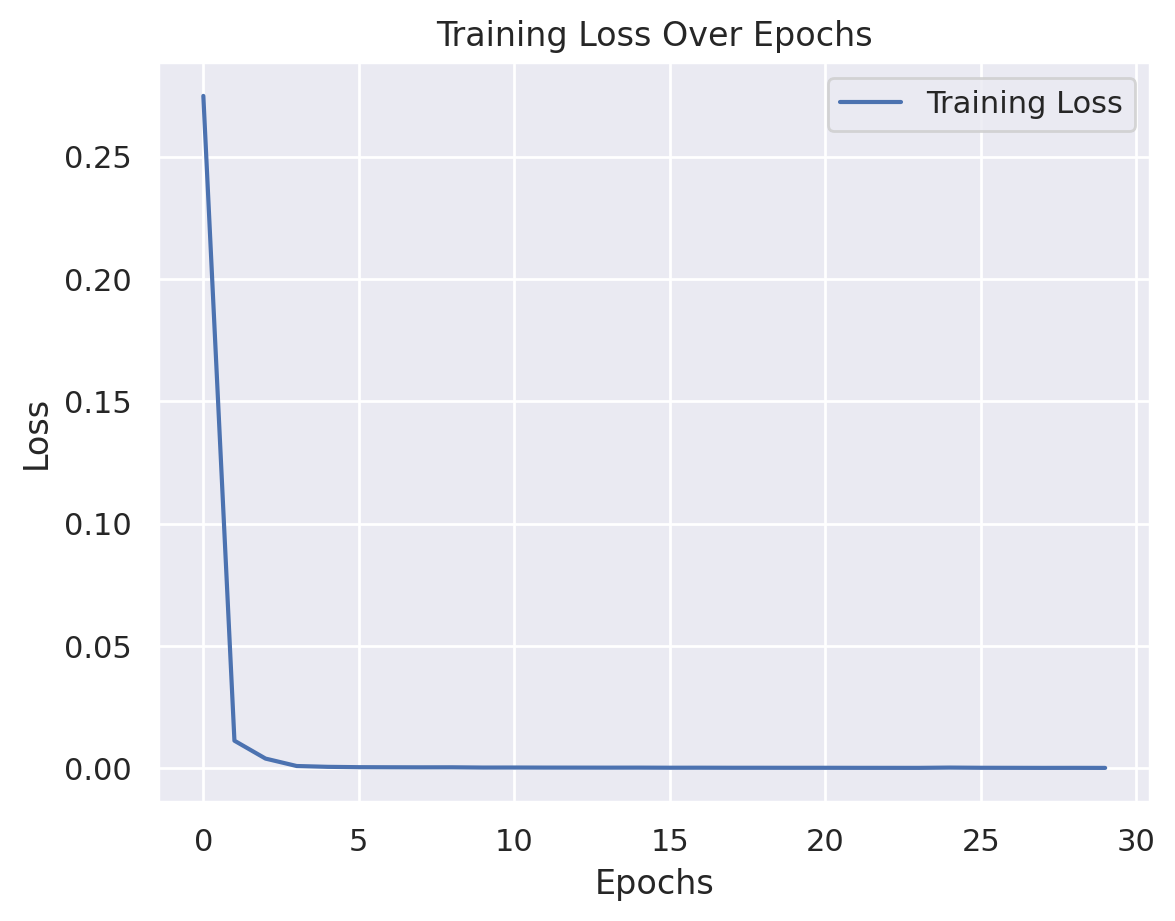

In [ ]:
# Training loop without validation
num_epochs = 15
print_every = 100  # Set the frequency for printing results (every 100 batches)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images).view(-1)
            loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        predictions = (outputs > 0).float()
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        # Print loss and accuracy for every 'print_every' batches
        if (batch_idx + 1) % print_every == 0:
            average_loss = total_loss / (batch_idx + 1)
            batch_accuracy = total_correct / total_samples
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Batch [{batch_idx + 1}/{len(train_dataloader)}], "
                  f"Loss: {average_loss:.4f}, "
                  f"Accuracy: {batch_accuracy:.4f}")

    # After the epoch ends, print final training metrics
    average_loss = total_loss / len(train_dataloader)
    train_losses.append(average_loss)

    # Print final training metrics at the end of the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {average_loss:.4f}, "
          f"Train Accuracy: {total_correct / total_samples:.4f}")

# Visualize training loss over epochs
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
